# Make plots to compare pretraining performances

In [1]:
import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

## Load performance data

In [19]:
filenames = [
    'out_coldStart_highCu_cls/all_pred_res.tsv',
    'out_coldStart_highCu_regr/all_pred_res.tsv',
    'out_warmStart_highCu_cls/all_pred_res.tsv',
    'out_warmStart_highCu_regr/all_pred_res.tsv',
    'out_warmStart_highCu_cls/evo_all_pred_res.tsv',
    'out_warmStart_highCu_regr/evo_all_pred_res.tsv'
]

df = pd.DataFrame()
for f in filenames:
    df = pd.concat([df,pd.read_csv(f,sep='\t')]).fillna('')

df['start'] = df['start'].apply(lambda x: x if x else "cold")
df

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,seq_mode,fold,best_val_score,epoch_stop,total_time,task,r2,pearson,spearman,start
0,highCu_cls_cv0,train,0.769461,0.977292,0.848867,1755.0,CNN,regular,0,0.635322,45,43.984181,highCu_cls,,,,cold
1,highCu_cls_cv0,test,0.366682,0.377125,0.369956,439.0,CNN,regular,0,0.635322,45,43.984181,highCu_cls,,,,cold
2,highCu_cls_cv1,train,0.695254,0.907145,0.771324,1755.0,CNN,regular,1,0.688871,26,41.303947,highCu_cls,,,,cold
3,highCu_cls_cv1,test,0.334506,0.341849,0.335291,439.0,CNN,regular,1,0.688871,26,41.303947,highCu_cls,,,,cold
4,highCu_cls_cv2,train,0.813636,0.969112,0.877543,1755.0,CNN,regular,2,0.641168,48,43.077116,highCu_cls,,,,cold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,warm_evo_highCu_reg_shuffled_cv2,test,,,,,CNN,shuffled,2,3.432019,59,43.442797,highCu_logTPM_regr,0.035639,0.191427,0.174922,model_evo_weights
16,warm_evo_highCu_reg_shuffled_cv3,train,,,,,CNN,shuffled,3,4.313764,66,43.837686,highCu_logTPM_regr,0.088273,0.320486,0.304678,model_evo_weights
17,warm_evo_highCu_reg_shuffled_cv3,test,,,,,CNN,shuffled,3,4.313764,66,43.837686,highCu_logTPM_regr,-0.010528,0.098761,0.115889,model_evo_weights
18,warm_evo_highCu_reg_shuffled_cv4,train,,,,,CNN,shuffled,4,4.642624,98,46.150665,highCu_logTPM_regr,0.084128,0.345922,0.330009,model_evo_weights


In [20]:
cdf = df[df['task']=='highCu_cls']
rdf = df[df['task']=='highCu_logTPM_regr']

In [39]:
cdf_test = cdf[cdf['split']=='test']
print(cdf_test.shape)
cdf_test['mac_f1'] = cdf_test['mac_f1'].astype(float)
cdf_test

(40, 17)


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,seq_mode,fold,best_val_score,epoch_stop,total_time,task,r2,pearson,spearman,start
1,highCu_cls_cv0,test,0.366682,0.377125,0.369956,439.0,CNN,regular,0,0.635322,45,43.984181,highCu_cls,,,,cold
3,highCu_cls_cv1,test,0.334506,0.341849,0.335291,439.0,CNN,regular,1,0.688871,26,41.303947,highCu_cls,,,,cold
5,highCu_cls_cv2,test,0.326221,0.330459,0.328305,439.0,CNN,regular,2,0.641168,48,43.077116,highCu_cls,,,,cold
7,highCu_cls_cv3,test,0.32366,0.320112,0.320801,439.0,CNN,regular,3,0.689606,31,41.726261,highCu_cls,,,,cold
9,highCu_cls_cv4,test,0.368135,0.358873,0.361878,438.0,CNN,regular,4,0.631235,26,41.284132,highCu_cls,,,,cold
11,highCu_cls_shuffled_cv0,test,0.325835,0.327488,0.326038,439.0,CNN,shuffled,0,0.615555,53,43.604510,highCu_cls,,,,cold
13,highCu_cls_shuffled_cv1,test,0.31153,0.29444,0.302658,439.0,CNN,shuffled,1,0.697113,41,43.838193,highCu_cls,,,,cold
15,highCu_cls_shuffled_cv2,test,0.343222,0.345902,0.343372,439.0,CNN,shuffled,2,0.712185,38,43.839131,highCu_cls,,,,cold
17,highCu_cls_shuffled_cv3,test,0.352755,0.360146,0.355981,439.0,CNN,shuffled,3,0.663091,64,45.708942,highCu_cls,,,,cold
19,highCu_cls_shuffled_cv4,test,0.319557,0.315421,0.317308,438.0,CNN,shuffled,4,0.685574,24,42.334432,highCu_cls,,,,cold


<AxesSubplot:xlabel='start', ylabel='mac_f1'>

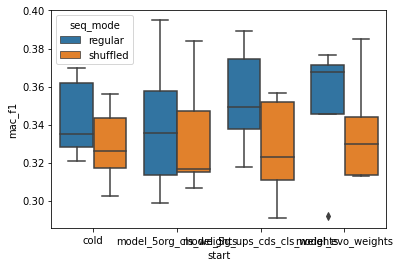

In [40]:
sns.boxplot(data=cdf_test,x='start',y='mac_f1',hue='seq_mode')

In [120]:
my_pal_list = [
    sns.color_palette("Set2")[2],
    sns.color_palette("Set2")[0],
    sns.color_palette("Set2")[4],
    sns.color_palette("Set2")[5],
]
my_pal = sns.color_palette(my_pal_list)
my_pal

[(0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961)]

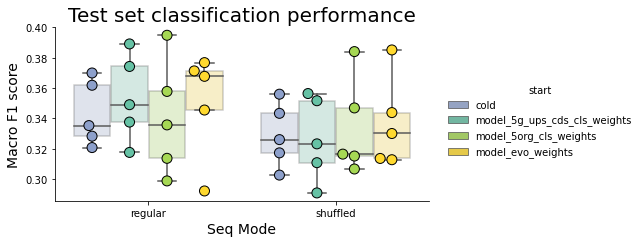

In [121]:
hue_order = ['cold','model_5g_ups_cds_cls_weights','model_5org_cls_weights','model_evo_weights']

g = sns.catplot(
    data=cdf_test, x='seq_mode', y='mac_f1',
    kind='box',hue='start',hue_order=hue_order,palette=my_pal,
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',hue='start',hue_order=hue_order,
                size=10, edgecolor='black',linewidth=1, dodge=True,palette=my_pal)

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set classification performance",fontsize=20)
plt.show()

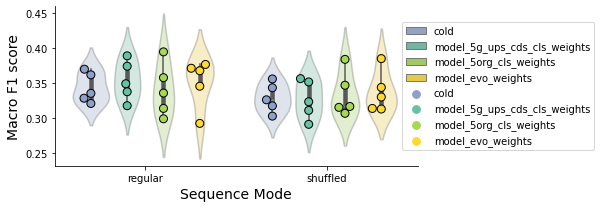

In [136]:
hue_order = ['cold','model_5g_ups_cds_cls_weights','model_5org_cls_weights','model_evo_weights']

g = sns.catplot(
    data=cdf_test, x='seq_mode', y='mac_f1',hue='start',
     kind='violin',hue_order=hue_order,legend=False,palette=my_pal,
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
plt.setp(g.ax.collections, alpha=.3)

g.map_dataframe(sns.swarmplot, x='seq_mode', y='mac_f1',hue='start',
                size=8, hue_order=hue_order,
                edgecolor='black',linewidth=1, dodge=True,palette=my_pal)

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Sequence Mode",fontsize=14)

#h,l = g.
# l = ['Starting Weights','Hell Yeh', 'Nah Bruh','test']
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5,0.5),loc='right')

plt.savefig('img/transfer_learning_violin_cls.png', dpi=300)

plt.show()



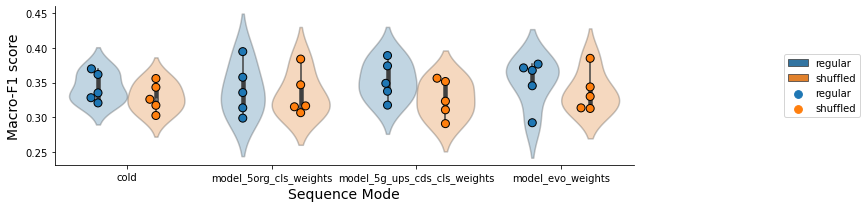

In [126]:
g = sns.catplot(
    data=cdf_test, x='start', y='mac_f1',hue='seq_mode',
     kind='violin',legend=False,
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)
plt.setp(g.ax.collections, alpha=.3)

g.map_dataframe(sns.swarmplot, x='start', y='mac_f1',hue='seq_mode',
                size=8, 
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro-F1 score', fontsize=14)
plt.xlabel("Sequence Mode",fontsize=14)

#h,l = g.
# l = ['Starting Weights','Hell Yeh', 'Nah Bruh','test']
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.4,0.5),loc='right')

#plt.savefig('img/transfer_learning_violin_regr.png', dpi=300)

plt.show()

In [91]:
rdf_test = rdf[rdf['split']=='test']
print(cdf_test.shape)
rdf_test['r2'] = rdf_test['r2'].astype(float)
rdf_test['pearson'] = rdf_test['pearson'].astype(float)
rdf_test

(40, 17)


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,seq_mode,fold,best_val_score,epoch_stop,total_time,task,r2,pearson,spearman,start
1,highCu_regr_cv0,test,,,,,CNN,regular,0,4.071888,110,48.971549,highCu_logTPM_regr,0.063358,0.259044,0.238527,cold
3,highCu_regr_cv1,test,,,,,CNN,regular,1,4.366968,87,46.944551,highCu_logTPM_regr,0.052716,0.230661,0.210085,cold
5,highCu_regr_cv2,test,,,,,CNN,regular,2,3.258085,105,48.191302,highCu_logTPM_regr,0.084513,0.292387,0.282982,cold
7,highCu_regr_cv3,test,,,,,CNN,regular,3,4.155636,102,47.862028,highCu_logTPM_regr,0.026515,0.187466,0.186481,cold
9,highCu_regr_cv4,test,,,,,CNN,regular,4,4.455547,92,47.352583,highCu_logTPM_regr,0.085216,0.303782,0.316751,cold
11,highCu_regr_shuffled_cv0,test,,,,,CNN,shuffled,0,4.188965,82,46.155121,highCu_logTPM_regr,0.036427,0.192286,0.176093,cold
13,highCu_regr_shuffled_cv1,test,,,,,CNN,shuffled,1,4.539700,50,44.260863,highCu_logTPM_regr,0.015247,0.123848,0.093579,cold
15,highCu_regr_shuffled_cv2,test,,,,,CNN,shuffled,2,3.401865,84,47.582538,highCu_logTPM_regr,0.044112,0.212063,0.190562,cold
17,highCu_regr_shuffled_cv3,test,,,,,CNN,shuffled,3,4.166752,76,46.705405,highCu_logTPM_regr,0.023911,0.156519,0.179626,cold
19,highCu_regr_shuffled_cv4,test,,,,,CNN,shuffled,4,4.578129,126,50.464115,highCu_logTPM_regr,0.060048,0.257981,0.263809,cold


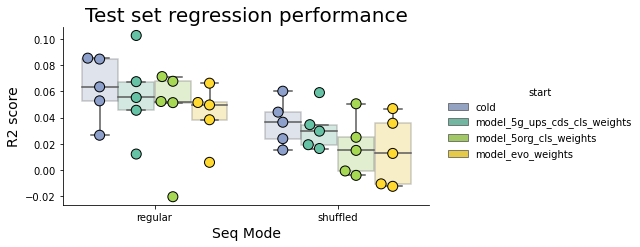

In [128]:
hue_order = ['cold','model_5g_ups_cds_cls_weights','model_5org_cls_weights','model_evo_weights']

g = sns.catplot(
    data=rdf_test, x='seq_mode', y='r2',
    kind='box',hue='start',hue_order=hue_order,palette=my_pal,
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',hue='start',hue_order=hue_order,
                size=10, edgecolor='black',linewidth=1, dodge=True,palette=my_pal,)

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

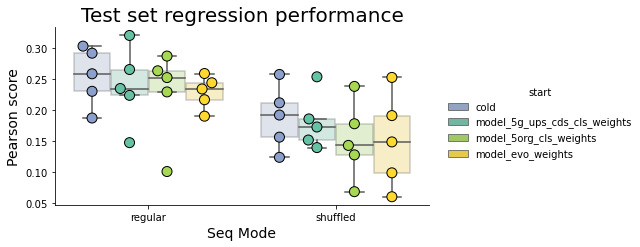

In [130]:
hue_order = ['cold','model_5g_ups_cds_cls_weights','model_5org_cls_weights','model_evo_weights']

g = sns.catplot(
    data=rdf_test, x='seq_mode', y='pearson',
    kind='box',hue='start',hue_order=hue_order,palette=my_pal,
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',hue='start',hue_order=hue_order,
                size=10, edgecolor='black',linewidth=1, dodge=True,palette=my_pal)

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

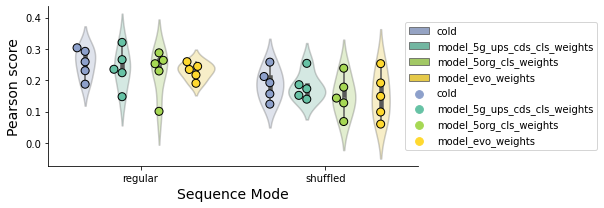

In [137]:
hue_order = ['cold','model_5g_ups_cds_cls_weights','model_5org_cls_weights','model_evo_weights']

g = sns.catplot(
    data=rdf_test, x='seq_mode', y='pearson',hue='start',
     kind='violin',hue_order=hue_order,legend=False,palette=my_pal,
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
plt.setp(g.ax.collections, alpha=.3)

g.map_dataframe(sns.swarmplot, x='seq_mode', y='pearson',hue='start',
                size=8, hue_order=hue_order,
                edgecolor='black',linewidth=1, dodge=True,palette=my_pal,)

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Pearson score', fontsize=14)
plt.xlabel("Sequence Mode",fontsize=14)

#h,l = g.
# l = ['Starting Weights','Hell Yeh', 'Nah Bruh','test']
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5,0.5),loc='right')

plt.savefig('img/transfer_learning_violin_regr.png', dpi=300)

plt.show()


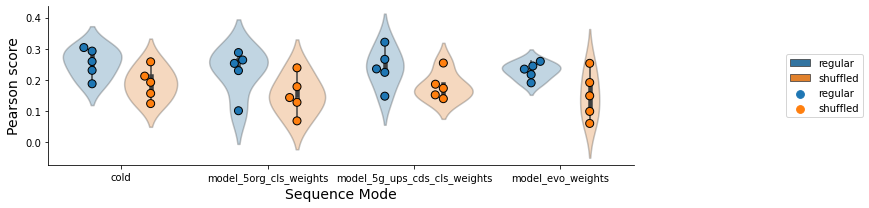

In [132]:
#hue_order = ['cold','model_5g_ups_cds_cls_weights','model_5org_cls_weights','model_evo_weights']

g = sns.catplot(
    data=rdf_test, x='start', y='pearson',hue='seq_mode',
     kind='violin',legend=False,
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)
plt.setp(g.ax.collections, alpha=.3)

g.map_dataframe(sns.swarmplot, x='start', y='pearson',hue='seq_mode',
                size=8, 
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Pearson score', fontsize=14)
plt.xlabel("Sequence Mode",fontsize=14)

#h,l = g.
# l = ['Starting Weights','Hell Yeh', 'Nah Bruh','test']
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.4,0.5),loc='right')

#plt.savefig('img/transfer_learning_violin_regr.png', dpi=300)

plt.show()